- 신경망 학습을 지원하는 PyTorch의 자동 미분 엔진

## 1. Background

- 신경망은 어떤 입력 데이터에 대해 실행되는 중첩되는 함수들의 모음
- 가중치와 편향으로 구성된 매개변수들로 정의

- 순전파(Forward Propagation) : 이 단계에서 신경망은 정답을 맞추기 위해 최선의 추측을 한다
- 역전파(Backward Propagation) : 추측한 값에서 발생한 오류에 비례하여 매개변수들을 적절히 조절. 출력으로부터 역방향으로 이동하면서 오류에 대한 함수들의 매개변수들의 미분값을 수집하고 경사하강법을 사용하여 매개변수들을 최적화

## 2. PyTorch에서 사용법

In [1]:
import torch,torchvision
model = torchvision.models.resnet18(pretrained = True)
data = torch.rand(1,3,64,64)
labels = torch.rand(1,1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/dongwook/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## **Resnet18**

- 2015년도 ILSVRC에서 우승한 CNN 네트워크
- ResNet 연구팀은 Layer가 너무 깊어져도 성능이 떨어진다는 현상을 확인
- Layer가 깊어질수록 미분을 점점 많이 하기에 Layer의 미분값이 작아져 weight(가중치)의 영향이 작아지는 Gradient Vanishing이 발생하여 Training Data로 학습이 되지 않는 문제가 발생
- ResNet은 Skip Connection을 이용한 Residual Learning을 통해 Gradient Vanishing 문제를 해결

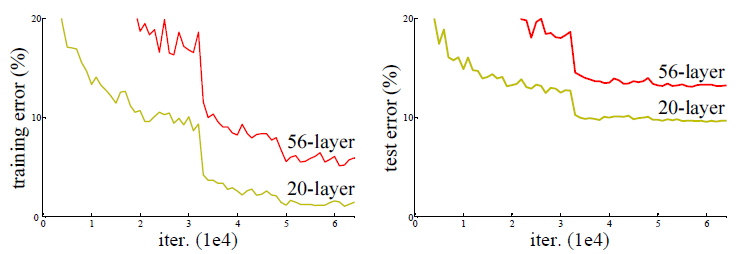

- 56개의 Layer 층을 쌓은 것보다 20개의 Layer 층을 쌓은 것이 더 나은 성능을 보이고 있음

### Identiy Block

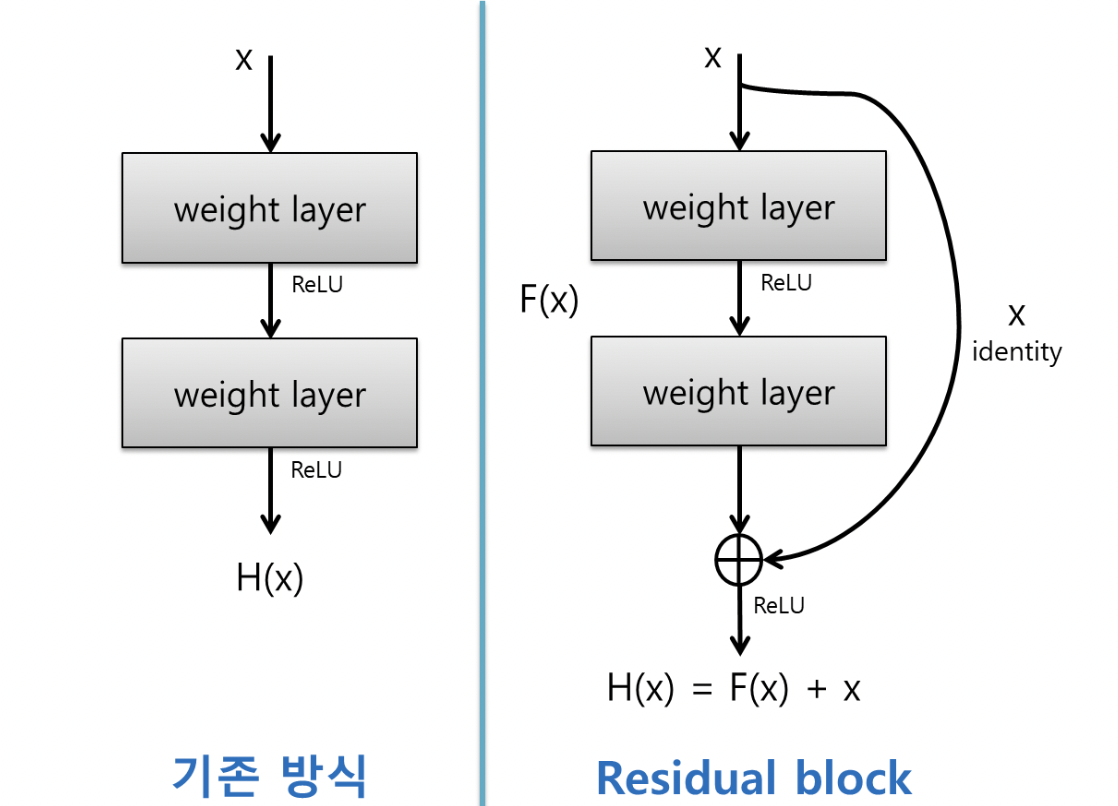

- 기존의 신경망은 입력값 x를 타겟값 y로 매핑하는 함수 H(x)를 얻는 것을 목적
- 그러나, ResNet은 F(x) + x를 최소화하는 것을 목적
- x는 현시점에서 변할 수 없는 값이므로 F(x)를 0에 가깝게 만드는 것이 목적
- F(x)가 0이 되면 출력과 입력이 모두 0으로 같아짐
- F(x) = H(x) - x이므로 F(x)를 최소로 해준다는 것은 H(x) - x를 최소로 해주는 것과 동일한 의미
- H(x) - x를 여기서 잔차(Residual)로 정의
- 즉, 잔차를 최소로 해주는 것이므로 ResNet이라는 이름이 붙게 된다.

### ResNet의 구조

- ResNet은 기본적으로 VGG-19의 구조가 뼈대
- 거기에 Convolution 층들을 추가해서 깊게 만든 후 shortcut들을 추가
- 34층의 ResNet과 거기에서 shortcut들을 제외한 버전인 plain 네트워크의 구조가 아래 사진

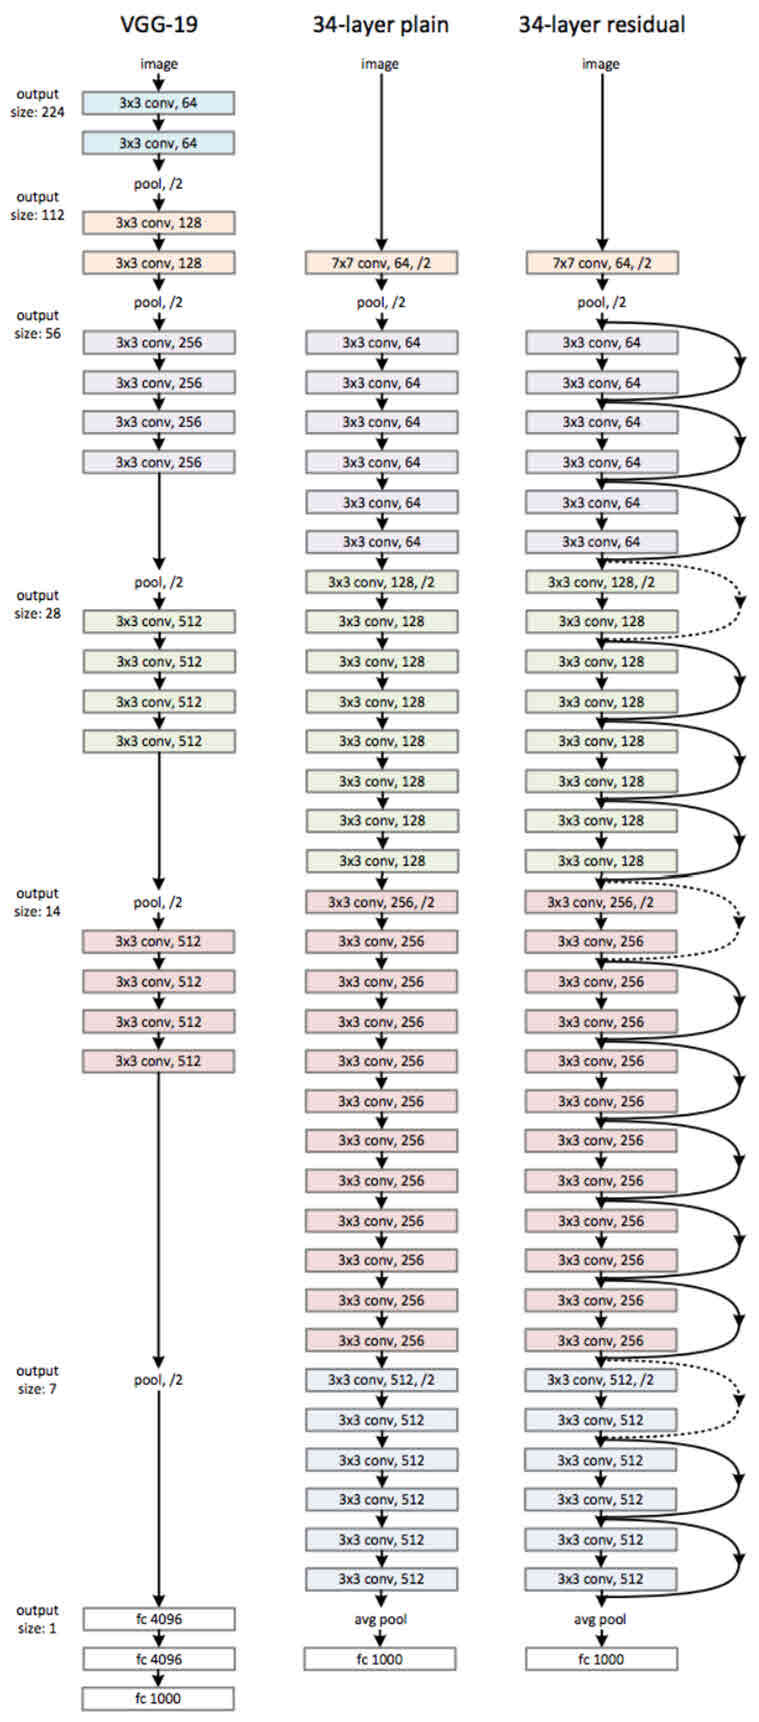

- 34층의 ResNet은 처음을 제외하고 균일하게 3x3 사이즈의 Convolution Filter 사용
- 그리고 Feature Map 사이즈가 반으로 줄어들 때, Feature Map의 Depth를 2배로 높임

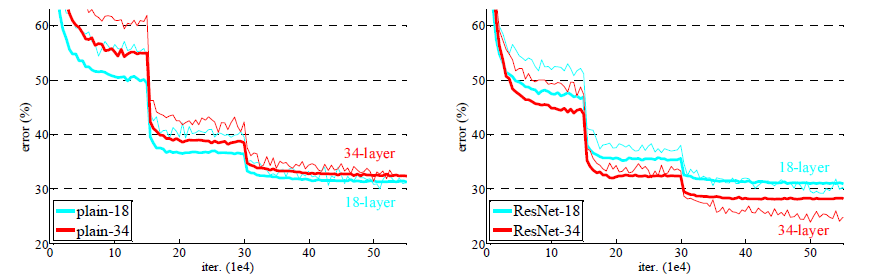

- 왼쪽은 plain, 오른쪽은 shortcut이 있는 ResNet
- 왼쪽은 망이 깊어지면서 오히려 에러가 커졌음을 알 수 있음
- 오른쪽은 망이 깊어지면서 에러 또한 작아졌음
- shortcut을 연결해서 잔차를 최소가 되게 학습한 효과가 있음
- 그래서 ResNet 성능 검증을 한 결과에 따르면 18, 34, 50, 101, 152층 중 152층에서의 ResNet 성능이 가장 뛰어났음

In [8]:
prediction = model(data) # 순전파 단계

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
loss = (prediction - labels).sum()
loss.backward() # 역전파 단계

In [10]:
optim = torch.optim.SGD(model.parameters(),lr = 1e-2, momentum = .9)

optim.step()

## 3. Autograd에서 미분(Differentiation)

In [1]:
import torch

In [2]:
a = torch.tensor([2.,3.],requires_grad = True)
b = torch.tensor([6.,4.],requires_grad = True)

#### a와 b로부터 새로운 텐서 Q 만들기

- $Q = 3a^3 - b^2$ 
- Q는 오차

In [3]:
q = 3*a**3 - b**2

- Q에 대해서 .backward()를 호출할 때, autograd는 이러한 변화도를 계산하고 이를 각 텐서의 .grad 속성에 저장

In [5]:
external_grad = torch.tensor([1.,1.])

In [6]:
q.backward(gradient = external_grad)

In [11]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])
